In [368]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
from datetime import datetime
import math
from sklearn.metrics import r2_score

## Data Import & Cleaning

In [369]:
all_data = pd.read_csv('eScooterDemand.csv')


Splitting the date into Month, Year and Day means that we can use them as features seperately

In [370]:
all_data['Date'] = pd.to_datetime(all_data['Date'], format='%d/%m/%Y')
all_data['Month'] = all_data['Date'].dt.month
all_data['Year'] = all_data['Date'].dt.year
all_data['Day'] = all_data['Date'].dt.day
all_data['Weekday'] = all_data['Date'].dt.weekday

all_data.drop(columns='Date', inplace=True)

In [371]:
print(all_data.head())

   Count  Hour  Temp  Humidity  Wind speed  Visibility  Dew point  Sunshine  \
0    254     0  -5.2        37         2.2        2000      -17.6       0.0   
1    204     1  -5.5        38         0.8        2000      -17.6       0.0   
2    173     2  -6.0        39         1.0        2000      -17.7       0.0   
3    107     3  -6.2        40         0.9        2000      -17.6       0.0   
4     78     4  -6.0        36         2.3        2000      -18.6       0.0   

   Rain  Snow  Season Public Holiday HireAvailable  Month  Year  Day  Weekday  
0   0.0   0.0  Winter             No           Yes     12  2017    1        4  
1   0.0   0.0  Winter             No           Yes     12  2017    1        4  
2   0.0   0.0  Winter             No           Yes     12  2017    1        4  
3   0.0   0.0  Winter             No           Yes     12  2017    1        4  
4   0.0   0.0  Winter             No           Yes     12  2017    1        4  


We can visualise these to see if there are any patterns suggesting that we should use them as features

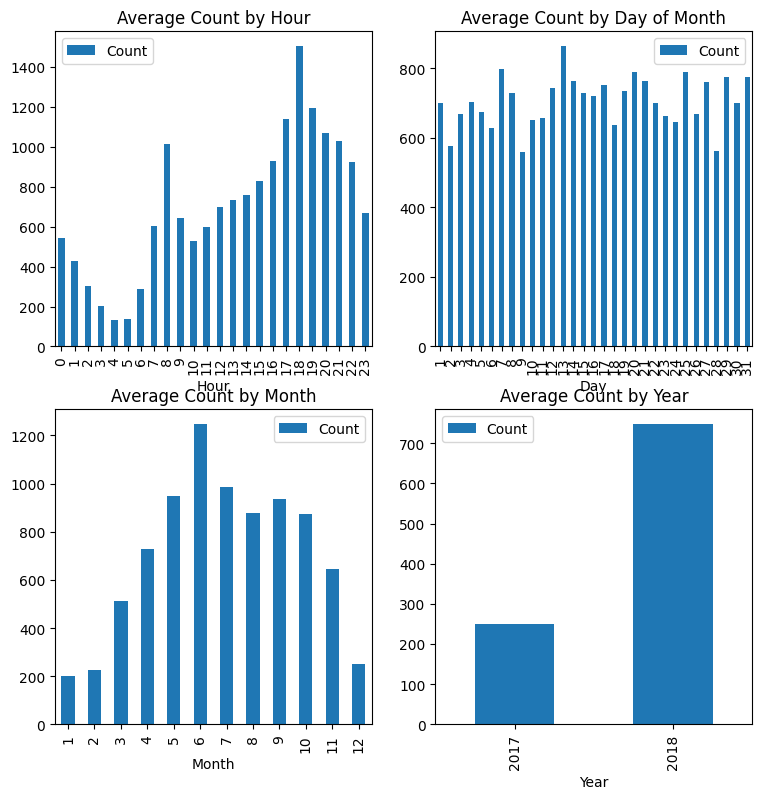

In [372]:
## Show all plots on one figure
fig, ax = plt.subplots(2, 2, figsize=(9, 9))
all_data.groupby('Hour').aggregate({'Count': 'mean'}).plot(kind='bar', ax=ax[0, 0], title='Average Count by Hour')
all_data.groupby('Day').aggregate({'Count': 'mean'}).plot(kind='bar', ax=ax[0, 1], title='Average Count by Day of Month')
all_data.groupby('Month').aggregate({'Count': 'mean'}).plot(kind='bar', ax=ax[1, 0], title='Average Count by Month')
all_data.groupby('Year').aggregate({'Count': 'mean'}).plot(kind='bar', ax=ax[1, 1], title='Average Count by Year')

plt.show()


The plots show that there is not any meaningful pattern or relation between the day of the month and the count, but there is for the hours, months and the year. Therefore we can drop the day column.

In [373]:
all_data.drop(columns="Day", inplace=True)

In [374]:
all_data.columns

Index(['Count', 'Hour', 'Temp', 'Humidity', 'Wind speed', 'Visibility',
       'Dew point', 'Sunshine', 'Rain', 'Snow', 'Season', 'Public Holiday',
       'HireAvailable', 'Month', 'Year', 'Weekday'],
      dtype='object')

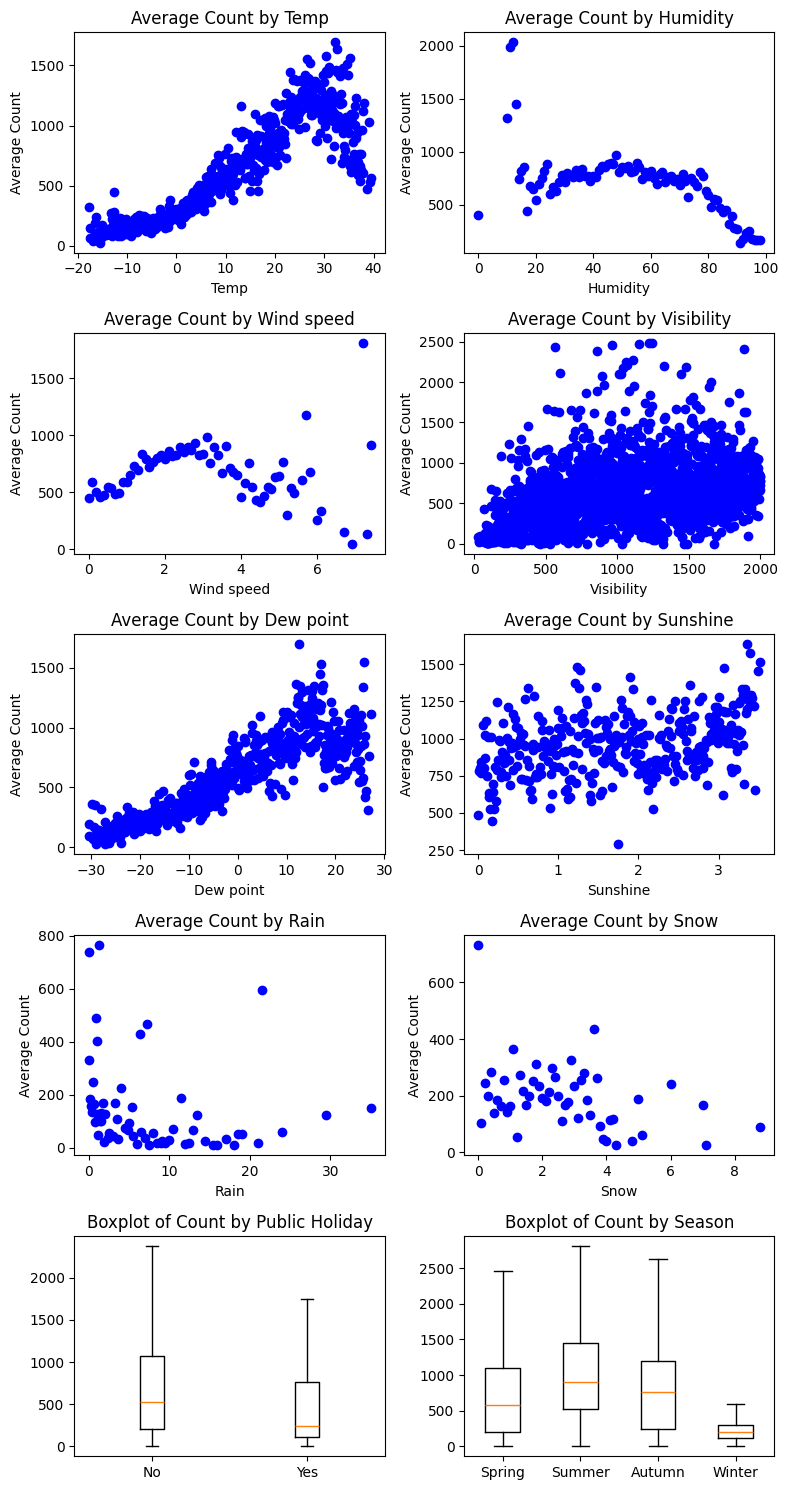

In [375]:

columns_to_plot = ['Temp', 'Humidity', 'Wind speed', 'Visibility', 'Dew point', 'Sunshine', 'Rain', 'Snow']

fig, ax = plt.subplots(5, 2, figsize=(8, 15))

ax = ax.flatten()

# Plot each column against the count of rentals
for i, col in enumerate(columns_to_plot):
    # Group data by the current column and calculate average count of rentals
    average_rental_counts = all_data.groupby(col)['Count'].mean().reset_index()
    
    # Plot the data
    ax[i].scatter(average_rental_counts[col], average_rental_counts['Count'], color='blue')
    ax[i].set_title(f'Average Count by {col}')
    ax[i].set_xlabel(col)
    ax[i].set_ylabel('Average Count')

# Plot boxplot for season in the last subplot
seasons = ['Spring', 'Summer', 'Autumn', 'Winter']
boxplot_data = [all_data[all_data['Season'] == season]['Count'] for season in seasons]
ax[-1].boxplot(boxplot_data, labels=seasons, showfliers=False)
ax[-1].set_title('Boxplot of Count by Season')

# boxplot for public holiday
public_holidays = ['No', 'Yes']
boxplot_data = [all_data[all_data['Public Holiday'] == holiday]['Count'] for holiday in public_holidays]
ax[-2].boxplot(boxplot_data, labels=public_holidays, showfliers=False)
ax[-2].set_title('Boxplot of Count by Public Holiday')

plt.tight_layout()

plt.show()

From this we can see that there is a clear causation between the number of scooters hired and the temperature, humidity, sunshine, windspeed and dew point as they show a gradient or bell curve in the diagrams. There is also a pattern to the average count relation to snow and rain.
We can also see a difference in means and ranges in the different seasons.
However the visibility data looks to not have a clear relationshop so we will drop this value for now.

In [376]:
all_data.drop(columns='Visibility', inplace=True) ## TODO: Test without this. It might be useful

In [377]:
all_data['HireAvailable'] = all_data['HireAvailable'].map({'Yes': 1, 'No': 0})
all_data['PublicHoliday'] = all_data['Public Holiday'].map({'Yes': 1, 'No': 0})

In [378]:
## Data standardisation
from sklearn import preprocessing

features = [
 'Temp',
 'Wind speed',
 'Dew point',
 'Sunshine',
 'Rain',
 'Snow',
 'Humidity']
print(all_data[features].describe())
safe = all_data[features].copy()
normalised_data = all_data.copy()

# for feature in features:
scaler = preprocessing.MinMaxScaler((0, 1))
# Fit the scaler to your data
scaler.fit(normalised_data[features])

# Transform the selected features
normalised_data[features] = scaler.transform(normalised_data[features])



              Temp   Wind speed    Dew point     Sunshine         Rain  \
count  8760.000000  8760.000000  8760.000000  8760.000000  8760.000000   
mean     12.882922     1.724909     4.073813     0.569111     0.148687   
std      11.944825     1.036300    13.060369     0.868746     1.128193   
min     -17.800000     0.000000   -30.600000     0.000000     0.000000   
25%       3.500000     0.900000    -4.700000     0.000000     0.000000   
50%      13.700000     1.500000     5.100000     0.010000     0.000000   
75%      22.500000     2.300000    14.800000     0.930000     0.000000   
max      39.400000     7.400000    27.200000     3.520000    35.000000   

              Snow     Humidity  
count  8760.000000  8760.000000  
mean      0.075068    58.226256  
std       0.436746    20.362413  
min       0.000000     0.000000  
25%       0.000000    42.000000  
50%       0.000000    57.000000  
75%       0.000000    74.000000  
max       8.800000    98.000000  


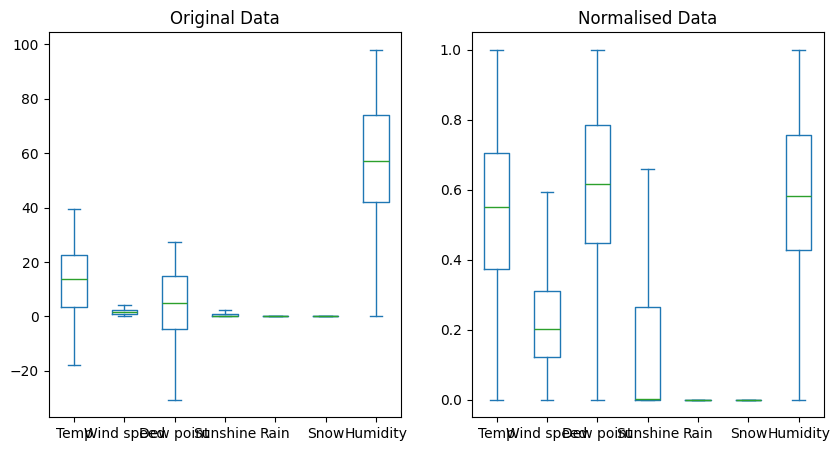

In [379]:
## visualise on boxplot
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
all_data[features].plot(kind='box', ax=ax[0], title='Original Data', showfliers=False)
normalised_data[features].plot(kind='box', ax=ax[1], title='Normalised Data', showfliers=False)
plt.show()


In [380]:
print(all_data[features].describe( ))
print(normalised_data[features].describe())
print(safe.describe())

              Temp   Wind speed    Dew point     Sunshine         Rain  \
count  8760.000000  8760.000000  8760.000000  8760.000000  8760.000000   
mean     12.882922     1.724909     4.073813     0.569111     0.148687   
std      11.944825     1.036300    13.060369     0.868746     1.128193   
min     -17.800000     0.000000   -30.600000     0.000000     0.000000   
25%       3.500000     0.900000    -4.700000     0.000000     0.000000   
50%      13.700000     1.500000     5.100000     0.010000     0.000000   
75%      22.500000     2.300000    14.800000     0.930000     0.000000   
max      39.400000     7.400000    27.200000     3.520000    35.000000   

              Snow     Humidity  
count  8760.000000  8760.000000  
mean      0.075068    58.226256  
std       0.436746    20.362413  
min       0.000000     0.000000  
25%       0.000000    42.000000  
50%       0.000000    57.000000  
75%       0.000000    74.000000  
max       8.800000    98.000000  
              Temp   Wind s

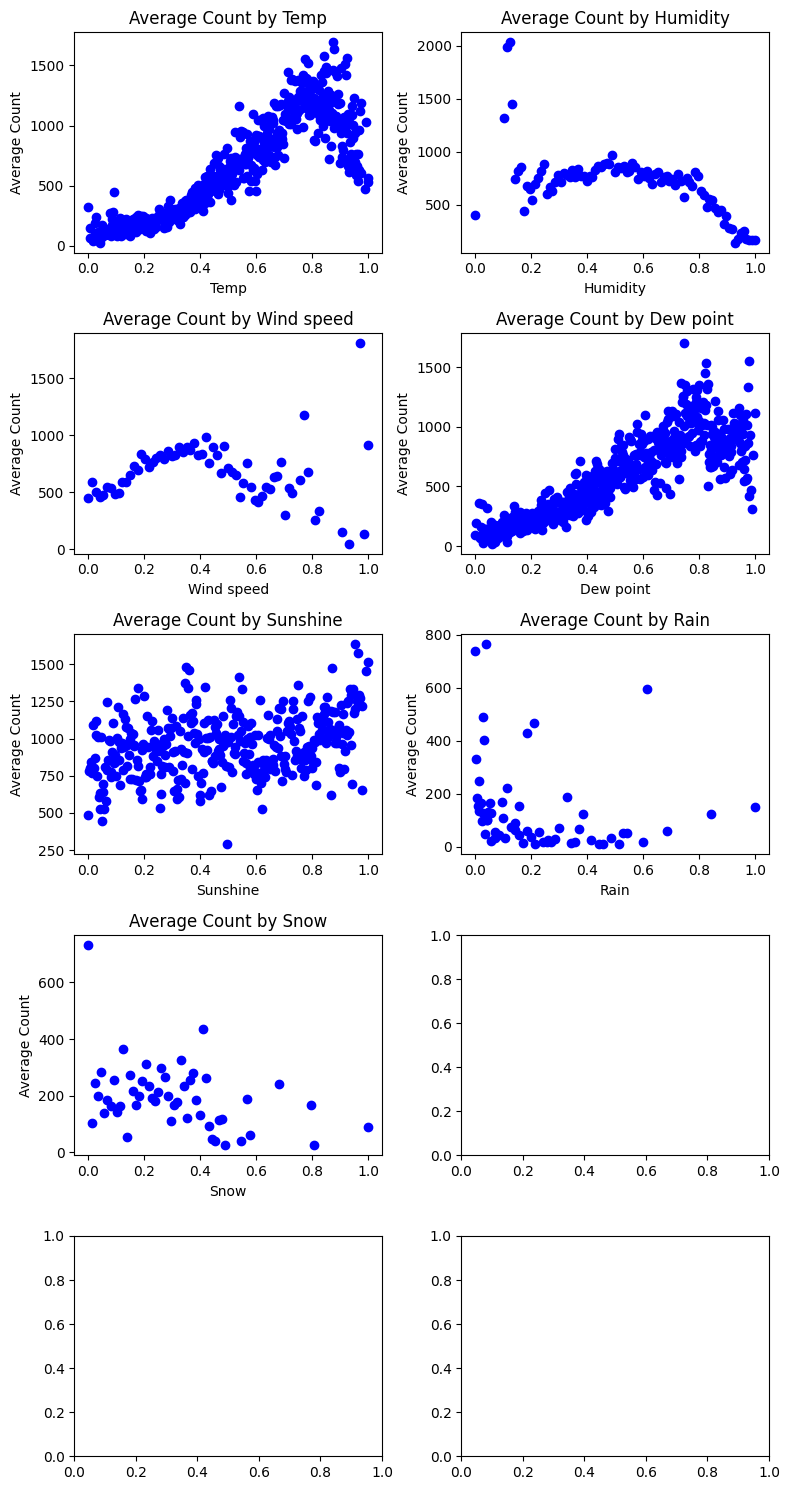

In [381]:

columns_to_plot = ['Temp', 'Humidity', 'Wind speed', 'Dew point', 'Sunshine', 'Rain', 'Snow']

fig, ax = plt.subplots(5, 2, figsize=(8, 15))

ax = ax.flatten()

# Plot each column against the count of rentals
for i, col in enumerate(columns_to_plot):
    # Group data by the current column and calculate average count of rentals
    average_rental_counts = normalised_data.groupby(col)['Count'].mean().reset_index()
    
    # Plot the data
    ax[i].scatter(average_rental_counts[col], average_rental_counts['Count'], color='blue')
    ax[i].set_title(f'Average Count by {col}')
    ax[i].set_xlabel(col)
    ax[i].set_ylabel('Average Count')

plt.tight_layout()
plt.show()

## Setting up our model
I will be using a multilayer perceptron with 2 hidden layers for my model. 
This is because I struggled to get good results with only 1 layer, and 3 layers took too long to train. 

In [382]:
class MLP(object):
    """
    Multi-layer perceptron class
    """
    def __init__(self, numInput, numHidden1, numHidden2, numOutput):
        """
        Constructor for the MLP class

        Args:
            numInput (int): Number of input nodes
            numHidden1 (int): Number of nodes in hidden layer 1
            numHidden2 (int): Number of nodes in hidden layer 2
            numOutput (int): Number of output nodes
        """
        
        self.fitness = 0
        self.numInput = numInput
        self.numHidden1 = numHidden1
        self.numHidden2 = numHidden2
        self.numOutput = numOutput

        # weights between layers are randomly initialized
        self.w_i_h1 = np.random.randn(self.numHidden1, self.numInput)
        self.w_h1_h2 = np.random.randn(self.numHidden2, self.numHidden1)
        self.w_h2_o = np.random.randn(self.numOutput, self.numHidden2)

        # bias between layers are initialized to 0
        self.b_i_h1 = [0] * numHidden1 
        self.b_i_h2 = [0] * numHidden2
        self.b_i_output = [0] * numOutput

        self.ReLU = lambda x : max(0,x)

    def sigmoid(self,x: float) -> float:
        """ Sigmoid activation function """
        try:
            ans = (1 / (1 + math.exp(-x)))
        except OverflowError:
            ans = float('inf')
        return ans

    def softmax(self, x: np.ndarray) -> np.ndarray:
        """ Compute softmax values for each sets of scores in x """
        e_x = np.exp(x - np.max(x))
        return e_x / e_x.sum()

    def feed_forward(self, inputs: np.ndarray, debug: bool = False) -> np.ndarray:
        
        if debug:
            print(f"Input: {inputs}")
            print(f"Hidden Layer 1 Weights: {self.w_i_h1}")
            print(f"Hidden Layer 2 Weights: {self.w_h1_h2}")
            print(f"Output Layer Weights: {self.w_h2_o}")
            print(f"Hidden Layer 1 Biases: {self.b_i_h1}")
            print(f"Hidden Layer 2 Biases: {self.b_i_h2}")
            print(f"Output Layer Biases: {self.b_i_output}")
            print("--------------------")

        h1 = np.dot(self.w_i_h1, inputs)             # feed input to hidden layer 1
        h1 = [h + b for h, b in zip(h1, self.b_i_h1)]

        if debug:
            print(f"Hidden Layer 1: {h1}")

        h1 = [self.ReLU(x) for x in h1]              # Activate hidden layer1

        if debug:
            print(f"Activated Hidden Layer 1: {h1}")
            print("--------------------")

        h2 = np.dot(self.w_h1_h2, h1)                # feed layer 1 to hidden layer 2
        h2 = [h + b for h, b in zip(h2, self.b_i_h2)]

        if debug:
            print(f"Hidden Layer 2: {h2}")

        h2 = [self.ReLU(x) for x in h2]              # Activate hidden layer 2

        if debug:
            print(f"Activated Hidden Layer 2: {h2}")
            print("--------------------")

        output = np.dot(self.w_h2_o, h2)             # feed to output layer
        output = [o + b for o, b in zip(output, self.b_i_output)]
        
        if debug:
            print(f"Output Layer: {output}")

        return output

We will be evolving the weights of the model in order to improve the performance of it, rather than using back propogation. Therefore we need to set up the functions for setting the weights and retrieving the weights.

In [383]:
class MLP(MLP):

  def set_weights_linear(self, Wgenome: np.ndarray):
        """Set the weights and biases from a linear genome. The genome is a flat array of weights and biases.
        The weights and biases are set in the order: w_i_h1, w_h1_h2, w_h2_o, b_i_h1, b_i_h2, b_i_output
        
        Args:
            Wgenome (array): The genome to set the weights and biases from
        """
        numWeights_I_H1 = self.numHidden1 * self.numInput
        numWeights_H1_H2 = self.numHidden2 * self.numHidden1
        numWeights_H2_O = self.numOutput * self.numHidden2

        # Weights (multi-dimensional arrays)

        first_slice_end = numWeights_I_H1

        self.w_i_h1 = np.array(Wgenome[:first_slice_end])
        self.w_i_h1 = self.w_i_h1.reshape((self.numHidden1, self.numInput))

        second_slice_end = first_slice_end + numWeights_H1_H2

        self.w_h1_h2 = np.array(Wgenome[first_slice_end:second_slice_end])
        self.w_h1_h2 = self.w_h1_h2.reshape((self.numHidden2, self.numHidden1))

        third_slice_end = second_slice_end + numWeights_H2_O

        self.w_h2_o = np.array(Wgenome[second_slice_end:third_slice_end])
        self.w_h2_o = self.w_h2_o.reshape((self.numOutput, self.numHidden2))

        # Biases (flat arrays for each layer)

        fourth_slice_end = third_slice_end + self.numHidden1

        self.b_i_h1 = np.array(Wgenome[third_slice_end:fourth_slice_end])

        fith_slice_end = fourth_slice_end + self.numHidden2

        self.b_i_h2 = np.array(Wgenome[fourth_slice_end:fith_slice_end])

        self.b_i_output = np.array(Wgenome[fith_slice_end:])

  def get_weights(self) -> np.ndarray:
        return np.concatenate((self.w_i_h1.flatten(), self.w_h1_h2.flatten(), self.w_h2_o.flatten(), self.b_i_h1, self.b_i_h2, self.b_i_output))

In [384]:
## Test the feed forward function
NLP = MLP(2, 3, 3, 1)
output = NLP.feed_forward(np.array([5, 5]), debug=True)
print(output)

Input: [5 5]
Hidden Layer 1 Weights: [[-0.33988035  1.2108089 ]
 [ 0.28760297  1.23563972]
 [ 0.76359098 -1.20619302]]
Hidden Layer 2 Weights: [[ 0.37228291 -0.27287677  1.28495239]
 [ 0.33324659  0.23292042  1.36997022]
 [-0.38749574 -0.17696082 -0.94726947]]
Output Layer Weights: [[-1.25343674  0.79808794  0.4837457 ]]
Hidden Layer 1 Biases: [0, 0, 0]
Hidden Layer 2 Biases: [0, 0, 0]
Output Layer Biases: [0]
--------------------
Hidden Layer 1: [4.354642759711512, 7.616213409878885, -2.2130102135438126]
Activated Hidden Layer 1: [4.354642759711512, 7.616213409878885, 0]
--------------------
Hidden Layer 2: [-0.4571286840620062, 3.225141474875661, -3.035176878501149]
Activated Hidden Layer 2: [0, 3.225141474875661, 0]
--------------------
Output Layer: [2.573946516114675]
[2.573946516114675]


## Setup for Genetic Programming

In [385]:
from deap import base, creator, tools, creator
# TODO: Discuss the parameters and choices

In [386]:
def setup(ind_size, eval_function, fitness_weights, init_min, init_max, mu = 0.0, sigma = 0.5, indpb = 0.4, seed=None):
    """Set up the DEAP toolbox and set the random seed to ensure reproducibility.

    Args:
        ind_size (int): The size of the individuals to create
        eval_function (function): The evaluation function to use
        fitness_weights (tuple): The weights for the fitness function
        init_min (float): The minimum value for the initialisation of genes
        init_max (float): The maximum value for the initialisation of genes
        seed (int): The random seed to use

    Returns:
        toolbox: The DEAP toolbox
    """
    if seed:
        random.seed(seed)

    # Create the DEAP creator for an individual
    creator.create("FitnessMax", base.Fitness, weights=fitness_weights)
    creator.create("Individual", list, fitness=creator.FitnessMax)

    # Create the DEAP toolbox
    toolbox = base.Toolbox()

    # Register the fitness function
    toolbox.register("evaluate", eval_function)

    # Create the individual
    toolbox.register("attr_float", random.uniform, init_min, init_max)
    toolbox.register("individual", tools.initRepeat, creator.Individual,
                     toolbox.attr_float, n=ind_size)
    
    toolbox.register("select", tools.selTournament, tournsize=3)

    toolbox.register("mutate", tools.mutGaussian, mu=mu, sigma=sigma, indpb=indpb) 

    toolbox.register("population", tools.initRepeat, list, toolbox.individual)

    return toolbox

# Investigation of parameters and representation

In [387]:
def eval_R2(individual, mlp, X, y):
    """Evaluate the fitness of the individual for the MLP

    Args:
        individual (list): The individual to evaluate
        mlp (MLP): The MLP to evaluate
        X (np.ndarray): The input data
        y (np.ndarray): The output data

    Returns:
        tuple: The fitness of the individual,
    """
    mlp.set_weights_linear(individual)
    y_pred = [mlp.feed_forward(x) for x in X]
    fitness = r2_score(y, y_pred)
    return fitness,

def eval_MSE(individual, mlp, X, y):
    """Evaluate the fitness of the individual for the MLP

    Args:
        individual (list): The individual to evaluate
        mlp (MLP): The MLP to evaluate
        X (np.ndarray): The input data
        y (np.ndarray): The output data

    Returns:
        tuple: The fitness of the individual,
    """
    mlp.set_weights_linear(individual)
    y_pred = [mlp.feed_forward(x) for x in X]
    fitness = np.mean((y - y_pred) ** 2)
    return fitness,

def eval_MAE(individual, mlp, X, y):
    """Evaluate the fitness of the individual for the MLP

    Args:
        individual (list): The individual to evaluate
        mlp (MLP): The MLP to evaluate
        X (np.ndarray): The input data
        y (np.ndarray): The output data

    Returns:
        tuple: The fitness of the individual,
    """
    mlp.set_weights_linear(individual)
    y_pred = [mlp.feed_forward(x) for x in X]
    fitness = np.mean(np.abs(y - y_pred))
    return fitness,

There are a number of things we need to investigate and find the best of
- Evaluation function (MAE, MSE, R2)
- Initialisation values
- Mu
- Sigma
- Indpb